In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.inspection import inspect
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

Base = automap_base()

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [21]:
# reflect an existing database into a new model

# reflect the tables

Base.prepare(engine, reflect=True)




In [22]:
# View all of the classes that automap found


In [23]:
# Save references to each table

Station = Base.classes.station
Measurement = Base.classes.measurement


In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
Last_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
Last_date = dt.date.fromisoformat(Last_date_str)
Last_date





datetime.date(2017, 8, 23)

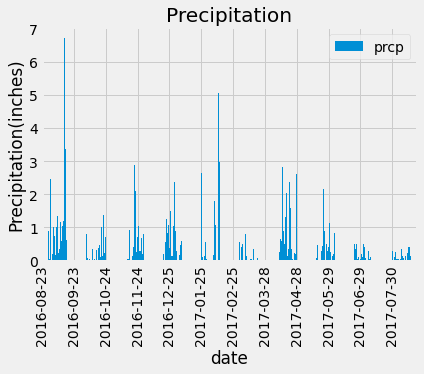

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

Prev_Last_date = dt.date(Last_date.year-1,Last_date.month,Last_date.day)
Prev_Last_date


# Perform a query to retrieve the data and precipitation scores
ann_prcp = session.query(Measurement.date,func.max(Measurement.prcp)).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Prev_Last_date)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()



# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(ann_prcp, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar()
#plt.tight_layout()
plt.xticks(rotation = 90)
plt.title("Precipitation")
plt.ylabel("Precipitation(inches)")
plt.locator_params(axis='x',nbins=12)
plt.show()




In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data

qy_ann_prcp = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Prev_Last_date)).\
    order_by(Measurement.date).all()

df_ann_prcp = pd.DataFrame(qy_ann_prcp, columns=['date', 'prcp'])
df_ann_prcp.set_index('date', inplace=True)
df_ann_prcp
ann_prcp_max = df_ann_prcp.groupby(["date"]).max()["prcp"] 
ann_prcp_min = df_ann_prcp.groupby(["date"]).min()["prcp"] 
ann_prcp_sum = df_ann_prcp.groupby(["date"]).sum()["prcp"] 
ann_prcp_count = df_ann_prcp.groupby(["date"]).count()["prcp"] 

dict_ann_prcp = {"Max": ann_prcp_max
                 ,"Min":ann_prcp_min
                 ,"Sum":ann_prcp_sum
                 ,"Count":ann_prcp_count 
                }

df_ann_prcp_summary = pd.DataFrame(dict_ann_prcp)
df_ann_prcp_summary



Max   Min   Sum  Count
date                               
2016-08-23  1.79  0.00  2.71      6
2016-08-24  2.28  0.08  9.33      6
2016-08-25  0.21  0.00  0.54      7
2016-08-26  0.04  0.00  0.10      6
2016-08-27  0.18  0.00  0.32      5
...          ...   ...   ...    ...
2017-08-19  0.09  0.00  0.09      3
2017-08-20  0.01  0.00  0.01      2
2017-08-21  0.56  0.00  0.58      3
2017-08-22  0.50  0.00  0.50      3
2017-08-23  0.45  0.00  0.53      4

[366 rows x 4 columns]

# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number stations in the dataset
active_stations = session.query(Station.station).count()

active_stations

9

In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
qry_most_active_stations = session.query(
        Measurement.station,
        func.count(Measurement.station)
    ).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())

all_most_active_stations = qry_most_active_stations.all()
all_most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = qry_most_active_stations.first()[0]
most_active_station_id

temp_summ = session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    ).\
    filter(Measurement.station == most_active_station_id).all()

temp_summ

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:>

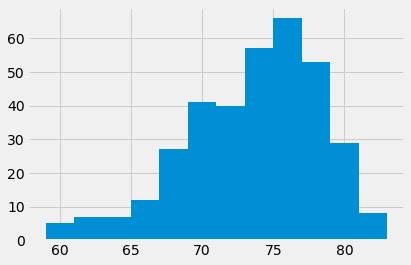

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

ann_tobs = session.query(Measurement.date,Measurement.tobs).\
    filter(
        Measurement.date >= func.strftime("%Y-%m-%d",Prev_Last_date), 
        Measurement.station == most_active_station_id
    ).\
    order_by(Measurement.date).all()

df = pd.DataFrame(ann_tobs, columns=['date', 'tobs'])

hist = df["tobs"].hist(bins=12)

hist

# Close session

In [53]:
# Close Session
session.close()